# Code part of the blog post

## Setup

In [22]:
from time import perf_counter
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

from ukf_pyrs import (
    UKF,
    FirstOrderTransitionFunction,
    SigmaPoints,
    measurement_function,
    transition_function,
    UKFParallel,
)
from ukf_pyrs.pinhole_camera import CameraProjector, PinholeCamera
import argparse


N_points = 50
point_a = np.array([-50, 0, 0])
point_b = np.array([0, 120, 130])
point_c = np.array([10, -10, 10]) * 2
t = np.linspace(0, 1, N_points)
dt = t[1] - t[0]
points = (1 - t)[:, None] * point_a[None, :] + t[:, None] * point_b[None, :]
points += (np.cos(t * np.pi) ** 2)[:, None] * point_c[None, :]
points = points.astype(np.float32)
np.random.seed(0)
rand_scale = 1
points_rand = (points + np.random.randn(*points.shape) * rand_scale).astype(np.float32)

cam1 = PinholeCamera.from_params(
    camera_position=np.array([50, 100, 0]),
    lookat_target=np.array([0, 0, 0]),
    fov_x_degrees=90,
    resolution=np.array([640, 480]),
)
cam2 = PinholeCamera.from_params(
    camera_position=np.array([-50, 80, 0]),
    lookat_target=np.array([0, 0, 0]),
    fov_x_degrees=90,
    resolution=np.array([640, 480]),
)
proj_points_obs1 = cam1.project(np.ascontiguousarray(points_rand[0::2])).reshape(-1, 2)
proj_points1 = cam1.project(points).reshape(-1, 2)
proj_points_obs2 = cam2.project(np.ascontiguousarray(points_rand[1::2])).reshape(-1, 2)
proj_points2 = cam2.project(points).reshape(-1, 2)

## Model problem

Let's go back to the beginning of this post. The setup is that we have 2 or more cameras that observe a moving person. Some machine learning algorithm will give us the 'keypoints' on the skeleton of the person (e.g. nose, left elbow, right knee, etc.). Our job is to turn these 2D positions (pixels on a camera) to positions in the real 3D world. 

I made a little simultation of a keypoint moving around in 3D and then projected it to the point of view of two cameras. This is what the cameras can see:

Text(0.5, 1.0, 'View from camera #2')

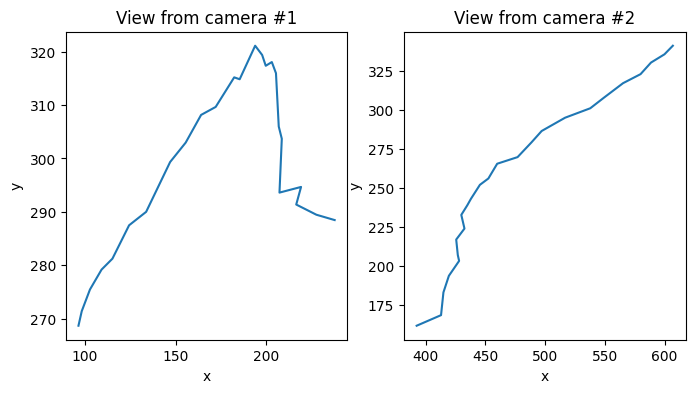

In [23]:

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.plot(*proj_points_obs1.T)
plt.xlabel("x")
plt.ylabel("y")
plt.title("View from camera #1")

plt.subplot(1,2,2)
plt.plot(*proj_points_obs2.T)
plt.xlabel("x")
plt.ylabel("y")
plt.title("View from camera #2")

Then to model this problem we will use a model dimension of $6$ (position+velocity) and 
a measurement dimension of 2 (pixels on a screen). 

The measurement function takes in two arguments; the position and an int denoting the camera number (this is something that we'll get back to later). To turn this function into an object that Rust can understand, we use the `@measurement_function` decorator.
The model transition function is just $(x,\,v)\mapsto (x+v\Delta t,\,v)$, and again we use a decorator to make our Rust implementation understand it.

In [24]:
dim_x = 6
dim_z = 2



@measurement_function(dim_z)
def h(x: np.ndarray, cam_id: int) -> np.ndarray:
    pos = x[:3]
    if cam_id == 0:
        return cam1.world_to_screen_single(pos)
    elif cam_id == 1:
        return cam2.world_to_screen_single(pos)
    else:
        return np.zeros(2, dtype=np.float32)


@transition_function
def f(x: np.ndarray, dt: float) -> np.ndarray:
    pos = x[:3]
    vel = x[3:]
    return np.concatenate([pos + vel * dt, vel])


Next we need to instantiate a class that can generate sigma points, and one that actually does the work of the Kalman filter. We then also set the values of the matrix $Q$, $R$ and the initial value of the matrix $P$ for the filter. 

We actually only changed the value of $Q$ from its default, it turned out to be OK for $P$ and $R$ to be the identity matrix. If you have a really good theoretical model, it can be possible to derive good values for these matrices. In practice though, you're just going to have to fiddle around with it. 

In [25]:
sigma_points = SigmaPoints.merwe(dim_x, 0.5, 2, -2)
kalman_filter = UKF(dim_x, dim_z, h, f, sigma_points)


kalman_filter.Q = np.diag([1e-2] * 3 + [3e1] * 3).astype(np.float32)
kalman_filter.R = np.eye(2).astype(np.float32)
kalman_filter.P = np.eye(6).astype(np.float32)


Next we're going to alternatively do a predict and update step from the point of view of either camera. To tell the Kalman filter which camera is making the observation we use the `update_measurement_context` method. Whatever value we pass here is what's going to get passed to the measurement function $h$. 

In [26]:


predictions_list = []
for p1, p2 in zip(
    proj_points_obs1, proj_points_obs2
):
    kalman_filter.update_measurement_context(0)
    kalman_filter.predict(dt)
    kalman_filter.update(p1)
    predictions_list.append(kalman_filter.x)

    kalman_filter.update_measurement_context(1)
    kalman_filter.predict(dt)
    kalman_filter.update(p2)
    predictions_list.append(kalman_filter.x)

predictions = np.array(predictions_list)  # type: ignore
pos_predictions = predictions[:, :3]

Then finally we are plotting the result below. We see that the Kalman filter is able to track the keypoint quite well in this problem. After taking a bit of time to settle it even gives an accurate estimate of the velocity of the keypoint!

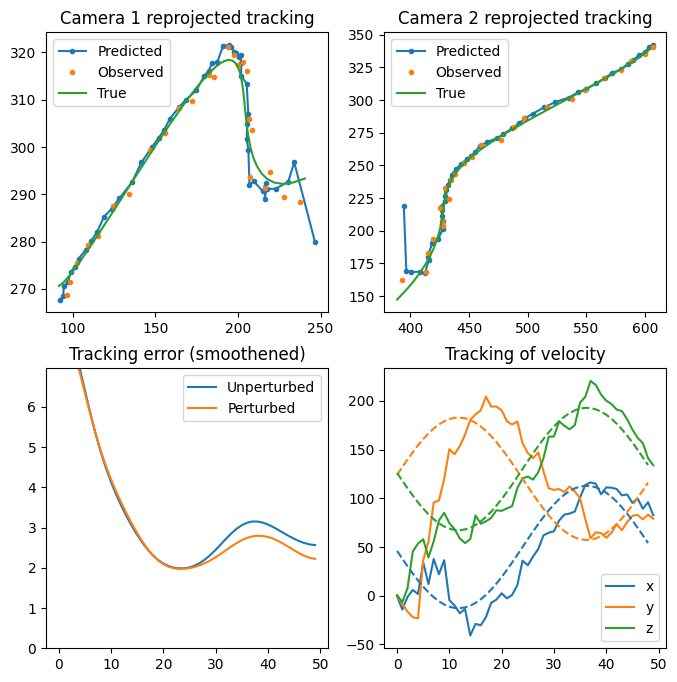

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.title("Camera 1 reprojected tracking")
plt.plot(
    *cam1.project(np.array(pos_predictions)).reshape(-1, 2).T, ".-", label="Predicted"
)
plt.plot(*proj_points_obs1.T, ".", label="Observed")
plt.plot(*proj_points1.T, "-", label="True")
plt.legend()

plt.subplot(2, 2, 2)
plt.title("Camera 2 reprojected tracking")
plt.plot(
    *cam2.project(np.array(pos_predictions)).reshape(-1, 2).T, ".-", label="Predicted"
)
plt.plot(*proj_points_obs2.T, ".", label="Observed")
plt.plot(*proj_points2.T, "-", label="True")
plt.legend()


plt.subplot(2, 2, 3)
plt.title("Tracking error (smoothened)")
sigma = 5
tracking_errors = np.linalg.norm(points - pos_predictions, axis=1)
tracking_errors_rand = np.linalg.norm(points_rand - pos_predictions, axis=1)
plt.plot(
    gaussian_filter1d(tracking_errors, sigma),
    label="Unperturbed",
)
plt.plot(
    gaussian_filter1d(tracking_errors_rand, sigma),
    label="Perturbed",
)
plt.ylim(0, np.mean(tracking_errors) * 2)
plt.legend()

plt.subplot(2, 2, 4)
plt.title("Tracking of velocity")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
names = ["x", "y", "z"]
for i, v in enumerate(predictions[:, 3:].T):
    plt.plot(v, color=colors[i], label=names[i])

velocity = np.diff(points, axis=0) / dt
for i, v in enumerate(velocity.T):
    plt.plot(v, color=colors[i], linestyle="--")
plt.legend()
plt.show()

## Make it blazingly fast